In [1]:
import pickle
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import zentables as zen

import time
import datetime

import warnings
warnings.filterwarnings(action='ignore')

print(datetime.datetime.now())

2023-02-09 18:05:14.472037


In [2]:
path_data = 'data/d20220201/'

# INPUTS
fn_finalSave = path_data + 'featuresAndMeta_s20220720.p'
fn_predictionsTraining  = path_data + 'predictionsTraining_binary_s20220704.xlsx'
fn_predictionsValidation = path_data + 'predictionsValidation_binary_s20220704.xlsx'

# OUTPUTS
#fn_figure_km = 'f_kapMeier_s20220718.svg'

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [3]:
with open(fn_finalSave, "rb") as input_file:
    dict_data = pickle.load(input_file)

dict_data.keys()

dict_keys(['df_rawFeatures_training', 'df_rawFeatures_validation', 'dict_normalizationFactors', 'df_zscoreFeatures_training', 'df_zscoreFeatures_validation', 'df_metadata', 'umap_raw', 'umap_zscore'])

In [4]:
predictions_train = pd.read_excel(fn_predictionsTraining, index_col=0)
predictions_validations = pd.read_excel(fn_predictionsValidation, index_col=0)
predictions_binary = pd.concat([predictions_train, predictions_validations])
predictions_binary['id'] = predictions_binary.index
predictions_binary['id'] = predictions_binary['id'].apply(lambda x: str(x).zfill(4))
predictions_binary = predictions_binary.set_index('id')

In [ ]:
predictions_binary[500:510]

In [6]:
currMeta = dict_data['df_metadata']
currMeta.isnull().sum()

trainTest               0
age                     0
sex                     0
ct_grp                  0
lre                   120
lre_tf                120
decompBL              120
lrd                   120
lrd_tf                120
survival              120
survival_tf           120
tfs                   120
tfs_tf                120
hvpg_corrected        120
hvpg_grp              120
decompensated_acld    120
hepLrd_time           120
hepLrd_180            120
hepLrd_360            120
cps                   120
cps_grp               120
meld                  120
meld_grp              120
etiology              120
sodium                120
creatinine            120
albumin               120
CRP                   120
INR                   120
bilirubin             120
cntl_grp                0
patientID               0
dtype: int64

In [ ]:
currMeta = currMeta.dropna()

# make variables
temp = pd.get_dummies(currMeta['meld_grp'], prefix='meldgrp')
currMeta = pd.concat([currMeta, temp], axis = 1)
temp = pd.get_dummies(currMeta['cps_grp'], prefix='cpsgrp')
currMeta = pd.concat([currMeta, temp], axis = 1)

# dummify categorical variables
currMeta['etio_alcLiverDisease'] = currMeta['etiology'].apply(lambda x: True if x == '1' else False)
currMeta['etio_nonAlcFattyLiver'] = currMeta['etiology'].apply(lambda x: True if x == '2' else False)
currMeta['etio_viral'] = currMeta['etiology'].apply(lambda x: True if x == '3' else False)
currMeta['etio_other'] = currMeta['etiology'].apply(lambda x: True if x == '4' else False)
currMeta['etio_unknown'] = currMeta['etiology'].apply(lambda x: True if x == '5' else False)

# add radipop predictions
currMeta = currMeta.merge(predictions_binary[['pred_bin']], how='inner', left_index=True, right_index=True)

# create composite endpoint: lre OR lrd
# currMeta['lre_or_lrd_tf'] = (~currMeta['decompBL'].astype(bool)) | (currMeta['lrd_tf']) # what celine thinks is correct
# #currMeta['lre_or_lrd_tf'] = (currMeta['decompBL'].astype(bool)) | (currMeta['lrd_tf'])
# currMeta['lre_or_lrd'] = currMeta[['lre','lrd']].min(axis=1)

currMeta

In [8]:
currMeta['meld_grp'].unique()

array(['2', '0', '1'], dtype=object)

In [ ]:
currMeta[['hvpg_corrected','pred_bin',  'lre_tf', 'lre',  'lrd_tf', 'lrd', 'survival_tf', 'survival']]

In [10]:
timetuples = [('lre', 'lre_tf')]
print(sum(currMeta['lre_tf']))
print(np.mean(currMeta['lre']))

198
27.97583454562222


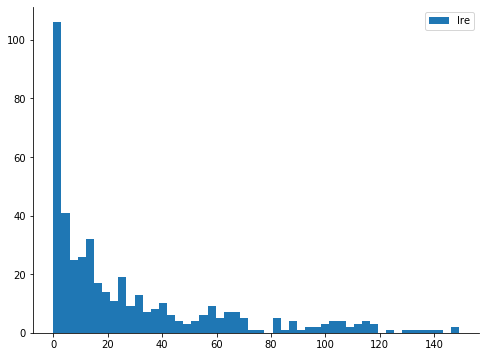

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
for eaTuple in timetuples:
    time = currMeta[eaTuple[0]]
    plt.hist(time, bins = 50, label=eaTuple[0])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['lre'])

Text(0, 0.5, 'Probability')

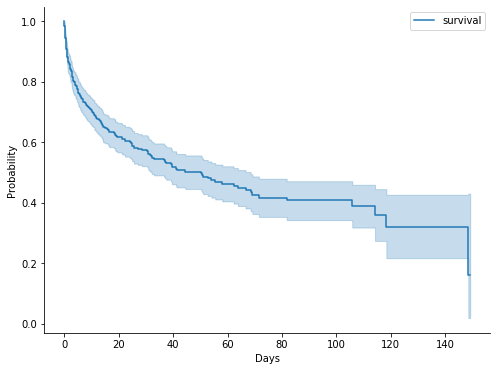

In [12]:
# for eaTuple in timetuples:
#     time = currMeta[eaTuple[0]]
#     status = currMeta[eaTuple[1]]
#     kmf = KaplanMeierFitter()
#     kmf.fit(durations = time, event_observed = status)
    
#     fig, ax = plt.subplots(figsize=(8, 6))
#     kmf.plot_survival_function()
#     plt.title(eaTuple[0])

fig, ax = plt.subplots(figsize=(8, 6))
for eaTuple in timetuples:
    time = currMeta[eaTuple[0]]
    status = currMeta[eaTuple[1]]
    kmf = KaplanMeierFitter()
    kmf.fit(durations = time, event_observed = status)
    kmf.plot_survival_function()
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['survival', 'lrd', 'tfs', 'lre'])
plt.xlabel('Days')
plt.ylabel('Probability')
#plt.savefig(fn_figure_km_big)

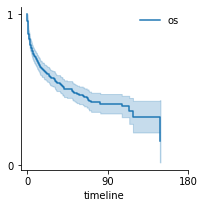

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))
for eaTuple in timetuples:
    time = currMeta[eaTuple[0]]
    status = currMeta[eaTuple[1]]
    kmf = KaplanMeierFitter()
    kmf.fit(durations = time, event_observed = status)
    kmf.plot_survival_function()

plt.yticks([0, 1])
plt.xticks([0, 90, 180])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['os', 'lrd', 'tfs', 'lre'], frameon=False)

#plt.savefig(fn_figure_km)

In [14]:
cov_sets = {#'cps': ['age', 'sex',
#                     'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#                     'cps_grp',
#                     'sodium', 'creatinine'],
#             'meld': ['age', 'sex',
#                      'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#                      'meld',
#                      'albumin'],
            'radipop': ['age',
                        'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other', 'etio_unknown',
                        'decompensated_acld', 
                        'sodium', 'creatinine', 'CRP', 'albumin',
                        'pred_bin'],
            'radipop+cps': ['etio_nonAlcFattyLiver', 'etio_viral', 'etio_other', 'etio_unknown',
                            'cpsgrp_2', 'cpsgrp_3',
                            'sodium', 'creatinine', 'CRP', 
                            'pred_bin'],
            'radipop+meld': ['etio_nonAlcFattyLiver', 'etio_viral', 'etio_other', 'etio_unknown',
                             'meld', 'decompensated_acld', 
                             'albumin', 'CRP',
                             'pred_bin'],            
#             'radipop_3g': ['age', 'sex',
#                         'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#                         'sodium', 'creatinine', 'CRP', 'bilirubin', 'albumin', 'INR', 
#                         'pred_3g'],
#             'radipop_3g+cps': ['age', 'sex',
#                             'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#                             'cps_grp',
#                             'sodium', 'creatinine',
#                             'pred_3g'],
#             'radipop_3g+meld': ['age', 'sex',
#                              'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#                              'meld',
#                              'albumin',
#                              'pred_3g'],               
#             'measured': ['age', 'sex',
#                          'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#                          'sodium', 'creatinine', 'CRP', 'bilirubin', 'albumin', 'INR', 
#                          'hvpg_corrected'], 
#             'measured+cps': ['age', 'sex',
#                             'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#                             'cps_grp',
#                             'sodium', 'creatinine',
#                             'hvpg_corrected'],
#             'measured+meld': ['age', 'sex',
#                              'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other',
#                              'meld',
#                              'albumin',
#                              'hvpg_corrected'],
            'meas_grp': ['age',
                         'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other', 'etio_unknown',
                         'decompensated_acld', 
                         'sodium', 'creatinine', 'CRP', 'albumin',
                         'hvpg_grp'], 
            'meas_grp+cps': ['etio_nonAlcFattyLiver', 'etio_viral', 'etio_other', 'etio_unknown',
                            'cpsgrp_2', 'cpsgrp_3',
                            'sodium', 'creatinine', 'CRP',
                            'hvpg_grp'],
            'meas_grp+meld': ['etio_nonAlcFattyLiver', 'etio_viral', 'etio_other', 'etio_unknown',
                             'meld',
                             'decompensated_acld', 
                             'albumin', 'CRP',
                             'hvpg_grp']
           }

In [54]:
dir(cph)

['AIC_',
 'AIC_partial_',
 '_ALLOWED_RESIDUALS',
 '_FAST_MEDIAN_PREDICT',
 '_KNOWN_MODEL',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_mode',
 '_censoring_type',
 '_central_values',
 '_check_values_post_fitting',
 '_check_values_pre_fitting',
 '_choose_gradient_calculator',
 '_class_name',
 '_clusters',
 '_compute_baseline_cumulative_hazard',
 '_compute_baseline_hazard',
 '_compute_baseline_hazards',
 '_compute_baseline_survival',
 '_compute_central_values_of_raw_training_data',
 '_compute_confidence_intervals',
 '_compute_delta_beta',
 '_compute_deviance',
 '_compute_martingale',
 '_compute_p_values',
 '_compute_sandwich_estimator',
 '_

In [56]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 442 total observations, 244 right-censored observations>
             duration col = 'lre'
                event col = 'lre_tf'
      baseline estimation = breslow
   number of observations = 442
number of events observed = 198
   partial log-likelihood = -1026.59
         time fit was run = 2023-02-09 18:39:20 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
etio_nonAlcFattyLiver   0.45       1.57       0.23            -0.01             0.90                 0.99                 2.47
etio_viral             -0.34       0.72       0.21            -0.75             0.08                 0.47                 1.09
etio_other             -0.02       0.98       0.23            -0.46             0.43                 0.63                 1.53
etio_unknown            0.19       1.21       0.47            -0.72             1.11                 0.48                 3.02
meld                    0.03       1.03       0.01             0.00             0.05                 1.00                 1.05
decompensated_acld      0.67       1.95       0.21             0.25             1.09                 1.28                 2.96
albumin                -0.04       0.96       0.02            -0.07            -0.01                 0.93                 0.99
CRP                     0.02       1.02       0.03            -0.03             0.08                 0.97                 1.08
hvpg_grp                0.21       1.24       0.09             0.03             0.39                 1.03                 1.48

                        cmp to     z      p   -log2(p)
covariate                                             
etio_nonAlcFattyLiver     0.00  1.93   0.05       4.23
etio_viral                0.00 -1.57   0.12       3.11
etio_other                0.00 -0.08   0.94       0.09
etio_unknown              0.00  0.41   0.68       0.55
meld                      0.00  2.26   0.02       5.39
decompensated_acld        0.00  3.12 <0.005       9.11
albumin                   0.00 -2.95 <0.005       8.29
CRP                       0.00  0.88   0.38       1.39
hvpg_grp                  0.00  2.27   0.02       5.44
---
Concordance = 0.74
Partial AIC = 2071.17
log-likelihood ratio test = 116.60 on 9 df
-log2(p) of ll-ratio test = 67.03

In [48]:
allModels={}
results = pd.DataFrame()

#for eaTuple in timetuples:
for eaTuple in [('lre', 'lre_tf')]:
    for eaCovset in cov_sets:
        curr_cov = copy.deepcopy(cov_sets[eaCovset])
        curr_cov.extend([eaTuple[0], eaTuple[1]])
        temp = currMeta[curr_cov]
        cph = CoxPHFitter()
        cph.fit(temp, duration_col = eaTuple[0], event_col = eaTuple[1])
        #cph.print_summary()
        modelname = eaTuple[0] + '_' + eaCovset
        allModels[modelname] = cph
        
        currResults = dict(cph.hazard_ratios_)
        currResults['AIC'] = cph.AIC_partial_
        currResults['Concordance'] = cph.concordance_index_
        curr_df = pd.DataFrame.from_dict(currResults, 
                                         orient='index',
                                         columns=[modelname])
        curr_df[modelname + '_pvalue'] = cph.summary['p']
        ci_df = np.exp(cph.confidence_intervals_)
        ci_df = ci_df.rename(columns={'95% lower-bound': modelname + '_lb', '95% upper-bound': modelname + '_ub'})
        results = pd.merge(results, ci_df, how='outer', left_index=True, right_index=True)
        results = pd.merge(results, curr_df, how='outer', left_index=True, right_index=True)

In [16]:
# reorder rows
orderIndex = ['age',
              'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other', 'etio_unknown',
              'sodium', 'creatinine', 'CRP', 'INR', 'bilirubin', 'albumin',
              'cpsgrp_1', 'cpsgrp_2', 'cpsgrp_3', 'meld', 'decompensated_acld',
              'pred_bin', 'hvpg_grp',
              'AIC', 'Concordance'
             ]
results = results.reindex(orderIndex)
results

,lre_radipop_lb,lre_radipop_ub,lre_radipop,lre_radipop_pvalue,lre_radipop+cps_lb,lre_radipop+cps_ub,lre_radipop+cps,lre_radipop+cps_pvalue,lre_radipop+meld_lb,lre_radipop+meld_ub,...,lre_meas_grp,lre_meas_grp_pvalue,lre_meas_grp+cps_lb,lre_meas_grp+cps_ub,lre_meas_grp+cps,lre_meas_grp+cps_pvalue,lre_meas_grp+meld_lb,lre_meas_grp+meld_ub,lre_meas_grp+meld,lre_meas_grp+meld_pvalue
age,1.003742,1.031632,1.017592,0.012626,NaN,NaN,NaN,NaN,NaN,NaN,...,1.015448,0.028257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
etio_alcLiverDisease,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
etio_nonAlcFattyLiver,1.099702,2.802327,1.755484,0.018362,0.983504,2.482991,1.562700,5.881714e-02,1.051060,2.616951,...,1.662939,0.032607,0.937470,2.357872,1.486753,9.188453e-02,0.993890,2.468609,1.566374,0.053167
etio_viral,0.492959,1.144381,0.751088,0.182778,0.422327,0.937304,0.629165,2.270715e-02,0.457077,1.051648,...,0.770876,0.227116,0.453397,1.022372,0.680838,6.383952e-02,0.470561,1.086417,0.715000,0.116030
etio_other,0.617033,1.468093,0.951767,0.823100,0.613011,1.453146,0.943819,7.928572e-01,0.617157,1.447172,...,1.001071,0.996290,0.642873,1.573634,1.005807,9.797732e-01,0.630255,1.533024,0.982952,0.939556
etio_unknown,0.364509,2.301073,0.915840,0.851637,0.425722,2.686675,1.069475,8.863555e-01,0.476735,2.965035,...,0.952889,0.918433,0.445515,2.817991,1.120472,8.089857e-01,0.484777,3.024705,1.210911,0.682003
sodium,0.922341,0.981560,0.951490,0.001734,0.933553,0.994441,0.963516,2.111967e-02,NaN,NaN,...,0.951126,0.001298,0.933774,0.993892,0.963364,1.903173e-02,NaN,NaN,NaN,NaN
creatinine,1.180282,1.898197,1.496799,0.000877,1.379481,2.185898,1.736492,2.607817e-06,NaN,NaN,...,1.474794,0.001224,1.348062,2.136732,1.697188,6.740414e-06,NaN,NaN,NaN,NaN
CRP,0.961847,1.066013,1.012592,0.633343,0.955013,1.056785,1.004611,8.586480e-01,0.966079,1.067951,...,1.019673,0.471612,0.967137,1.072655,1.018531,4.870231e-01,0.971749,1.077922,1.023460,0.380700
INR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# univariable
allCov = ['age',
          'sodium', 'creatinine', 'CRP', 'albumin',
          'meld', 'decompensated_acld', 
          'pred_bin', 'hvpg_grp', 'hvpg_corrected']

uniResults = {}
uni_df = pd.DataFrame()

#for eaTuple in timetuples:
for eaTuple in [('lre', 'lre_tf')]:
    for eaCov in allCov:
        temp = currMeta[[eaCov, eaTuple[0], eaTuple[1]]]
        cph = CoxPHFitter()
        cph.fit(temp, duration_col = eaTuple[0], event_col = eaTuple[1])
        uniResults[eaCov] = {}
        uniResults[eaCov]['Univariate'] = cph.hazard_ratios_[0]
        uniResults[eaCov]['lb'] = np.exp(cph.confidence_intervals_.values.tolist()[0][0])
        uniResults[eaCov]['ub'] = np.exp(cph.confidence_intervals_.values.tolist()[0][1])
        uniResults[eaCov]['pvalue'] = cph.summary['p'][0]
    uniResults['etio_alcLiverDisease'] = {}
    uniResults['etio_alcLiverDisease']['Univariate'] = 1
    curr_df = pd.DataFrame.from_dict(uniResults,
                                     orient='index')

    uni_df = pd.merge(uni_df, curr_df, how='outer', left_index=True, right_index=True)

    
# univariable for dummyfied
covList = ['etio_nonAlcFattyLiver', 'etio_viral', 'etio_other', 'etio_unknown']

for eaTuple in [('lre', 'lre_tf')]:
    covList.append(eaTuple[0])
    covList.append(eaTuple[1])
    temp = currMeta[covList]
    cph = CoxPHFitter()
    cph.fit(temp, duration_col = eaTuple[0], event_col = eaTuple[1])
    hr_df = cph.hazard_ratios_
    ci_df = np.exp(cph.confidence_intervals_)
    p_df = cph.summary['p']
    temp = pd.merge(hr_df, ci_df, how='outer', left_index=True, right_index=True)
    temp = pd.merge(temp, p_df, how='outer', left_index=True, right_index=True)
    temp = temp.rename(columns={'95% lower-bound': 'lb', '95% upper-bound': 'ub', 'exp(coef)': 'Univariate', 'p': 'pvalue'})
    uni_df = pd.concat([uni_df, temp])
    
covList = ['cpsgrp_2', 'cpsgrp_3']

for eaTuple in [('lre', 'lre_tf')]:
    covList.append(eaTuple[0])
    covList.append(eaTuple[1])
    temp = currMeta[covList]
    cph = CoxPHFitter()
    cph.fit(temp, duration_col = eaTuple[0], event_col = eaTuple[1])
    hr_df = cph.hazard_ratios_
    ci_df = np.exp(cph.confidence_intervals_)
    p_df = cph.summary['p']
    temp = pd.merge(hr_df, ci_df, how='outer', left_index=True, right_index=True)
    temp = pd.merge(temp, p_df, how='outer', left_index=True, right_index=True)
    temp = temp.rename(columns={'95% lower-bound': 'lb', '95% upper-bound': 'ub', 'exp(coef)': 'Univariate', 'p': 'pvalue'})
    uni_df = pd.concat([uni_df, temp])

allResults = pd.merge(results, uni_df, how='outer', left_index=True, right_index=True)
allResults.head()

,lre_radipop_lb,lre_radipop_ub,lre_radipop,lre_radipop_pvalue,lre_radipop+cps_lb,lre_radipop+cps_ub,lre_radipop+cps,lre_radipop+cps_pvalue,lre_radipop+meld_lb,lre_radipop+meld_ub,...,lre_meas_grp+cps,lre_meas_grp+cps_pvalue,lre_meas_grp+meld_lb,lre_meas_grp+meld_ub,lre_meas_grp+meld,lre_meas_grp+meld_pvalue,Univariate,lb,ub,pvalue
AIC,NaN,NaN,2051.777908,NaN,NaN,NaN,2038.134366,NaN,NaN,NaN,...,2040.314636,NaN,NaN,NaN,2071.171621,NaN,NaN,NaN,NaN,NaN
CRP,0.961847,1.066013,1.012592,0.633343,0.955013,1.056785,1.004611,0.858648,0.966079,1.067951,...,1.018531,0.487023,0.971749,1.077922,1.023460,0.3807,1.091049,1.049177,1.134592,0.000013
Concordance,NaN,NaN,0.754044,NaN,NaN,NaN,0.764956,NaN,NaN,NaN,...,0.762748,NaN,NaN,NaN,0.735189,NaN,NaN,NaN,NaN,NaN
INR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,1.003742,1.031632,1.017592,0.012626,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.002584,0.990849,1.014459,0.667441


In [18]:

multicolumns = [np.array(['Univariable', 'Univariable', 'Model 1', 'Model 1', 'Model 2', 'Model 2']),
                np.array(['HR (95%CI)', 'pvalue', 'aHR (95%CI)', 'pvalue', 'aHR (95%CI)', 'pvalue'])]
shortResults_2a = pd.DataFrame(columns=multicolumns)

shortResults_2a['Univariable', 'HR (95%CI)'] = allResults.apply(lambda x: "%0.2f (%0.2f-%0.2f)" %(x['Univariate'], x['lb'], x['ub']), axis=1)
shortResults_2a['Model 1', 'aHR (95%CI)'] = allResults.apply(lambda x: "%0.2f (%0.2f-%0.2f)" %(x['lre_radipop+cps'], x['lre_radipop+cps_lb'], x['lre_radipop+cps_ub']), axis=1)
shortResults_2a['Model 2', 'aHR (95%CI)'] = allResults.apply(lambda x: "%0.2f (%0.2f-%0.2f)" %(x['lre_radipop+meld'], x['lre_radipop+meld_lb'], x['lre_radipop+meld_ub']), axis=1)
shortResults_2a['Univariable', 'pvalue'] = allResults['pvalue'].apply(lambda x: "%0.3f" %x if x>0.001 else "<0.001")
shortResults_2a['Model 1', 'pvalue'] = allResults['lre_radipop+cps_pvalue'].apply(lambda x: "%0.3f" %x if x>0.001 else "<0.001")
shortResults_2a['Model 2', 'pvalue'] = allResults['lre_radipop+meld_pvalue'].apply(lambda x: "%0.3f" %x if x>0.001 else "<0.001")

shortResults_2a['Univariable', 'HR (95%CI)']['etio_alcLiverDisease'] = 1
shortResults_2a['Model 1', 'aHR (95%CI)']['etio_alcLiverDisease'] = 1
shortResults_2a['Model 2', 'aHR (95%CI)']['etio_alcLiverDisease'] = 1
shortResults_2a['Univariable', 'pvalue']['etio_alcLiverDisease'] = ''
shortResults_2a['Model 1', 'pvalue']['etio_alcLiverDisease'] = ''
shortResults_2a['Model 2', 'pvalue']['etio_alcLiverDisease'] = ''

shortResults_2a['Univariable', 'HR (95%CI)']['CTP score'] = ''
shortResults_2a['Model 1', 'aHR (95%CI)']['CTP score'] = ''
shortResults_2a['Model 2', 'aHR (95%CI)']['CTP score'] = ''
shortResults_2a['Univariable', 'pvalue']['CTP score'] = ''
shortResults_2a['Model 1', 'pvalue']['CTP score'] = ''
shortResults_2a['Model 2', 'pvalue']['CTP score'] = ''

shortResults_2a['Univariable', 'HR (95%CI)']['cpsgrp_1'] = 1
shortResults_2a['Model 1', 'aHR (95%CI)']['cpsgrp_1'] = 1
shortResults_2a['Model 2', 'aHR (95%CI)']['cpsgrp_1'] = 1
shortResults_2a['Univariable', 'pvalue']['cpsgrp_1'] = ''
shortResults_2a['Model 1', 'pvalue']['cpsgrp_1'] = ''
shortResults_2a['Model 2', 'pvalue']['cpsgrp_1'] = ''

# reorder rows
orderIndex = ['age',
              'Etiology',
              'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other', 'etio_unknown',
              'CTP score', 'cpsgrp_1', 'cpsgrp_2', 'cpsgrp_3', 'meld', 'decompensated_acld', 
              'sodium', 'creatinine', 'albumin', 'CRP', 
              'pred_bin', #'hvpg_corrected', 'hvpg_grp',
              #'AIC', 'Concordance'
             ]
shortResults_2a = shortResults_2a.reindex(orderIndex)

shortResults_2a = shortResults_2a.reindex(orderIndex)
shortResults_2a = shortResults_2a.rename({'age': 'Age',
                                          'etio_alcLiverDisease': 'ALD',
                                          'etio_nonAlcFattyLiver': 'NAFLD',
                                          'etio_viral': 'Viral',
                                          'etio_other': 'Other',
                                          'etio_unknown': 'Unknown',
                                          'cpsgrp_1': 'A',
                                          'cpsgrp_2': 'B',
                                          'cpsgrp_3': 'C',
                                          'meld': 'UNOS MELD (2016) score, point',
                                          'decompensated_acld': 'Decompensated vs compensated ACLD',
                                          'sodium': 'Sodium, mmol x L-1', 
                                          'creatinine': 'Creatinine, mg x dL-1', 
                                          'CRP': 'CRP, mg x L-1', 
                                          'albumin': 'Albumin, g x L-1',
                                          'pred_bin': 'Predicted HVPG >=10 vs <10 mmHg'})

shortResults_2a.zen.pretty()

In [19]:
multicolumns = [np.array(['Univariable', 'Univariable', 'Model 1', 'Model 1', 'Model 2', 'Model 2']),
                np.array(['HR (95%CI)', 'pvalue', 'aHR (95%CI)', 'pvalue', 'aHR (95%CI)', 'pvalue'])]
shortResults_2b = pd.DataFrame(columns=multicolumns)

shortResults_2b['Univariable', 'HR (95%CI)'] = allResults.apply(lambda x: "%0.2f (%0.2f-%0.2f)" %(x['Univariate'], x['lb'], x['ub']), axis=1)
shortResults_2b['Model 1', 'aHR (95%CI)'] = allResults.apply(lambda x: "%0.2f (%0.2f-%0.2f)" %(x['lre_meas_grp+cps'], x['lre_meas_grp+cps_lb'], x['lre_meas_grp+cps_ub']), axis=1)
shortResults_2b['Model 2', 'aHR (95%CI)'] = allResults.apply(lambda x: "%0.2f (%0.2f-%0.2f)" %(x['lre_meas_grp+meld'], x['lre_meas_grp+meld_lb'], x['lre_meas_grp+meld_ub']), axis=1)
shortResults_2b['Univariable', 'pvalue'] = allResults['pvalue'].apply(lambda x: "%0.3f" %x if x>0.001 else "<0.001")
shortResults_2b['Model 1', 'pvalue'] = allResults['lre_meas_grp+cps_pvalue'].apply(lambda x: "%0.3f" %x if x>0.001 else "<0.001")
shortResults_2b['Model 2', 'pvalue'] = allResults['lre_meas_grp+meld_pvalue'].apply(lambda x: "%0.3f" %x if x>0.001 else "<0.001")

shortResults_2b['Univariable', 'HR (95%CI)']['etio_alcLiverDisease'] = 1
shortResults_2b['Model 1', 'aHR (95%CI)']['etio_alcLiverDisease'] = 1
shortResults_2b['Model 2', 'aHR (95%CI)']['etio_alcLiverDisease'] = 1
shortResults_2b['Univariable', 'pvalue']['etio_alcLiverDisease'] = ''
shortResults_2b['Model 1', 'pvalue']['etio_alcLiverDisease'] = ''
shortResults_2b['Model 2', 'pvalue']['etio_alcLiverDisease'] = ''

shortResults_2b['Univariable', 'HR (95%CI)']['CTP score'] = ''
shortResults_2b['Model 1', 'aHR (95%CI)']['CTP score'] = ''
shortResults_2b['Model 2', 'aHR (95%CI)']['CTP score'] = ''
shortResults_2b['Univariable', 'pvalue']['CTP score'] = ''
shortResults_2b['Model 1', 'pvalue']['CTP score'] = ''
shortResults_2b['Model 2', 'pvalue']['CTP score'] = ''

shortResults_2b['Univariable', 'HR (95%CI)']['cpsgrp_1'] = 1
shortResults_2b['Model 1', 'aHR (95%CI)']['cpsgrp_1'] = 1
shortResults_2b['Model 2', 'aHR (95%CI)']['cpsgrp_1'] = 1
shortResults_2b['Univariable', 'pvalue']['cpsgrp_1'] = ''
shortResults_2b['Model 1', 'pvalue']['cpsgrp_1'] = ''
shortResults_2b['Model 2', 'pvalue']['cpsgrp_1'] = ''


# reorder rows
orderIndex = ['age',
              'Etiology',
              'etio_alcLiverDisease', 'etio_nonAlcFattyLiver', 'etio_viral', 'etio_other', 'etio_unknown',
              'CTP score', 'cpsgrp_1', 'cpsgrp_2', 'cpsgrp_3', 'meld', 'decompensated_acld', 
              'sodium', 'creatinine', 'albumin', 'CRP', 
              'hvpg_grp',
              #'AIC', 'Concordance'
             ]
shortResults_2b = shortResults_2b.reindex(orderIndex)
shortResults_2b = shortResults_2b.rename({'age': 'Age',
                                          'etio_alcLiverDisease': 'ALD',
                                          'etio_nonAlcFattyLiver': 'NAFLD',
                                          'etio_viral': 'Viral',
                                          'etio_other': 'Other',
                                          'etio_unknown': 'Unknown',
                                          'cpsgrp_1': 'A',
                                          'cpsgrp_2': 'B',
                                          'cpsgrp_3': 'C',
                                          'meld': 'UNOS MELD (2016) score, point',
                                          'decompensated_acld': 'Decompensated vs compensated ACLD',
                                          'sodium': 'Sodium, mmol x L-1', 
                                          'creatinine': 'Creatinine, mg x dL-1', 
                                          'CRP': 'CRP, mg x L-1', 
                                          'albumin': 'Albumin, g x L-1',
                                          'hvpg_grp': 'HVPG >=10 vs <10 mmHg'})

shortResults_2b.zen.pretty()

In [44]:
multicolumns = [np.array(['Model 1', 'Model 1', 'Model 2', 'Model 2']),
                np.array(['Predicted HVPG categories', 'Measured HVPG categories', 'Predicted HVPG categories', 'Measured HVPG categories'])]
shortResults_3 = pd.DataFrame(columns=multicolumns)

temp = allResults[['lre_radipop+cps', 'lre_meas_grp+cps',  'lre_radipop+meld', 'lre_meas_grp+meld']]
temp = temp.reindex(['AIC', 'Concordance'])

shortResults_3['Model 1', 'Predicted HVPG categories'] = temp['lre_radipop+cps'].apply(lambda x: "%0.3f" %x)
shortResults_3['Model 1', 'Measured HVPG categories'] = temp['lre_meas_grp+cps'].apply(lambda x: "%0.3f" %x)
shortResults_3['Model 2', 'Predicted HVPG categories'] = temp['lre_radipop+cps'].apply(lambda x: "%0.3f" %x)
shortResults_3['Model 2', 'Measured HVPG categories'] = temp['lre_meas_grp+cps'].apply(lambda x: "%0.3f" %x)

shortResults_3.zen.pretty()

In [20]:
print(datetime.datetime.now())

2023-02-09 18:05:20.476610
